# Finding chromosomal distribution of miRNA binding and non-binding sites

this will define the state distribution?

can also do for negative state (other state)?

Then feeding the state distributions and some "fake"
transition probabilities into the hmm in pomegranate
will estimate real transition probabilities, correct? 

-FW: Yes, this is correct in my mind. 
-NG: Awesome, we're on the same page! haha

Finding chromosomal distribution
of miRNA binding and non-binding sites

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# upload positive set
pfile="~/GitHub/HMMicro/CLIP_data/HEK293/Hafner.combined_AGO.proc.hg19.chr22.trimmed.bed"
pmatrix_full = pd.read_table(pfile,sep="\t",names=["chr","s","e"])

# upload negative set
nfile="~/GitHub/HMMicro/data/negative_set.bed"
nmatrix_full = pd.read_table(nfile,sep="\t",names=["chr","s","e","name","strand","something"])

In [2]:
#Here I'm counting the start of mirna sites
#that occur after a quantile (right word?)
#of the length of chr22
quants=np.arange(0,1.05,0.05)
pcounts=[0]*20
chrLen=51304566
for i in pmatrix_full.s:
    ma=max(quants[i>quants*chrLen])
    index=np.nonzero(quants == ma)[0][0]
    pcounts[index]+=1
    
quants=np.arange(0,1.05,0.05)
ncounts=[0]*20
for i in nmatrix_full.s:
    ma=max(quants[i>quants*chrLen])
    if ma == 1.0:
        ma = quants[19]
    index=np.nonzero(quants == ma)[0][0]
    ncounts[index]+=1

In [3]:
#for example, at index 9 or after 9*0.05% of
#the chr22 sequence, 37 mirna sites are observed
#before 10*0.05% of chr22 has been traversed
#
#in other words, 37 mirna sites are obserrved between
#45 and 50% of the chr22 sequence
#
#positive set
print(pcounts)
#
#negative set
print(ncounts)

[0, 0, 0, 0, 0, 0, 3, 25, 37, 13, 5, 42, 51, 9, 34, 48, 52, 12, 11, 20]
[33, 39, 42, 44, 41, 34, 38, 38, 42, 38, 38, 44, 40, 44, 38, 41, 34, 32, 46, 16573]


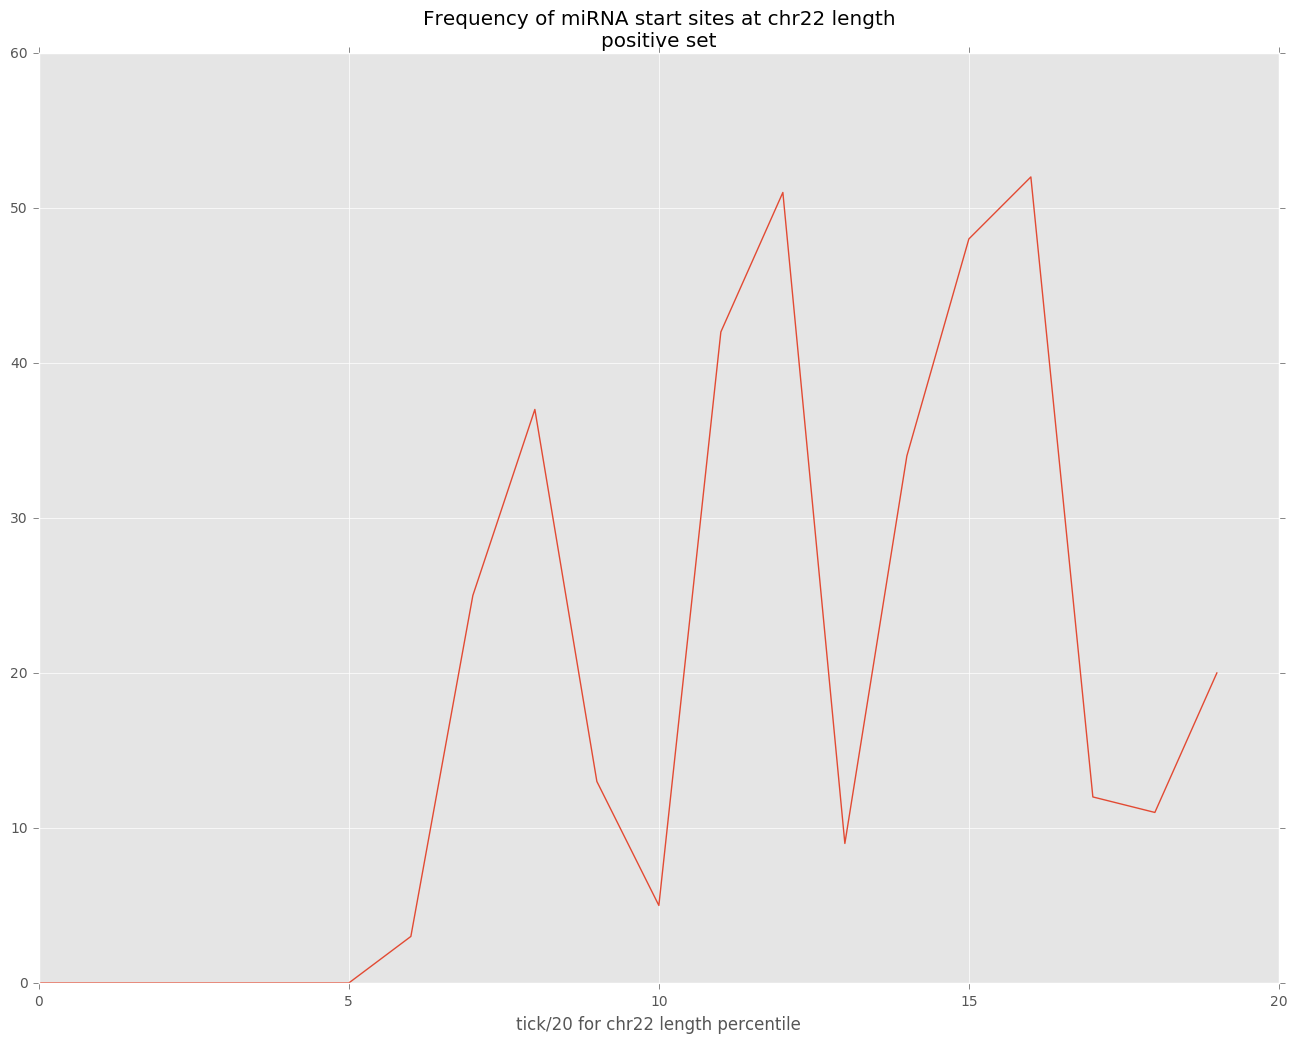

In [22]:
plt.plot(pcounts)
plt.title("Frequency of miRNA start sites at chr22 length\npositive set")
plt.xlabel("tick/20 for chr22 length percentile")
plt.show()

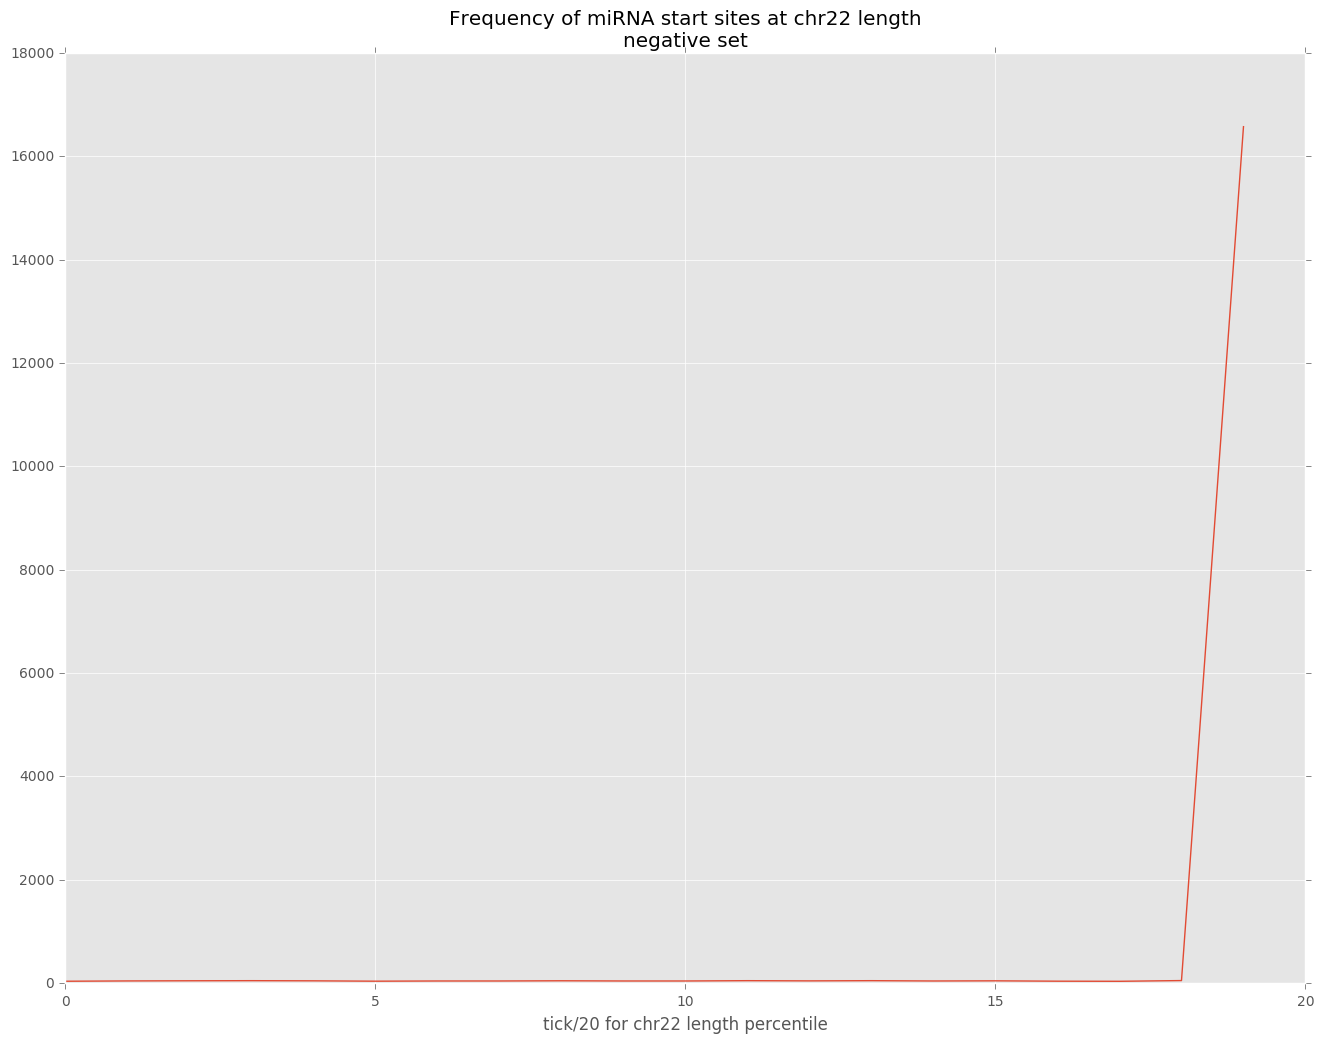

In [23]:
plt.plot(ncounts)
plt.title("Frequency of miRNA start sites at chr22 length\nnegative set")
plt.xlabel("tick/20 for chr22 length percentile")
plt.show()

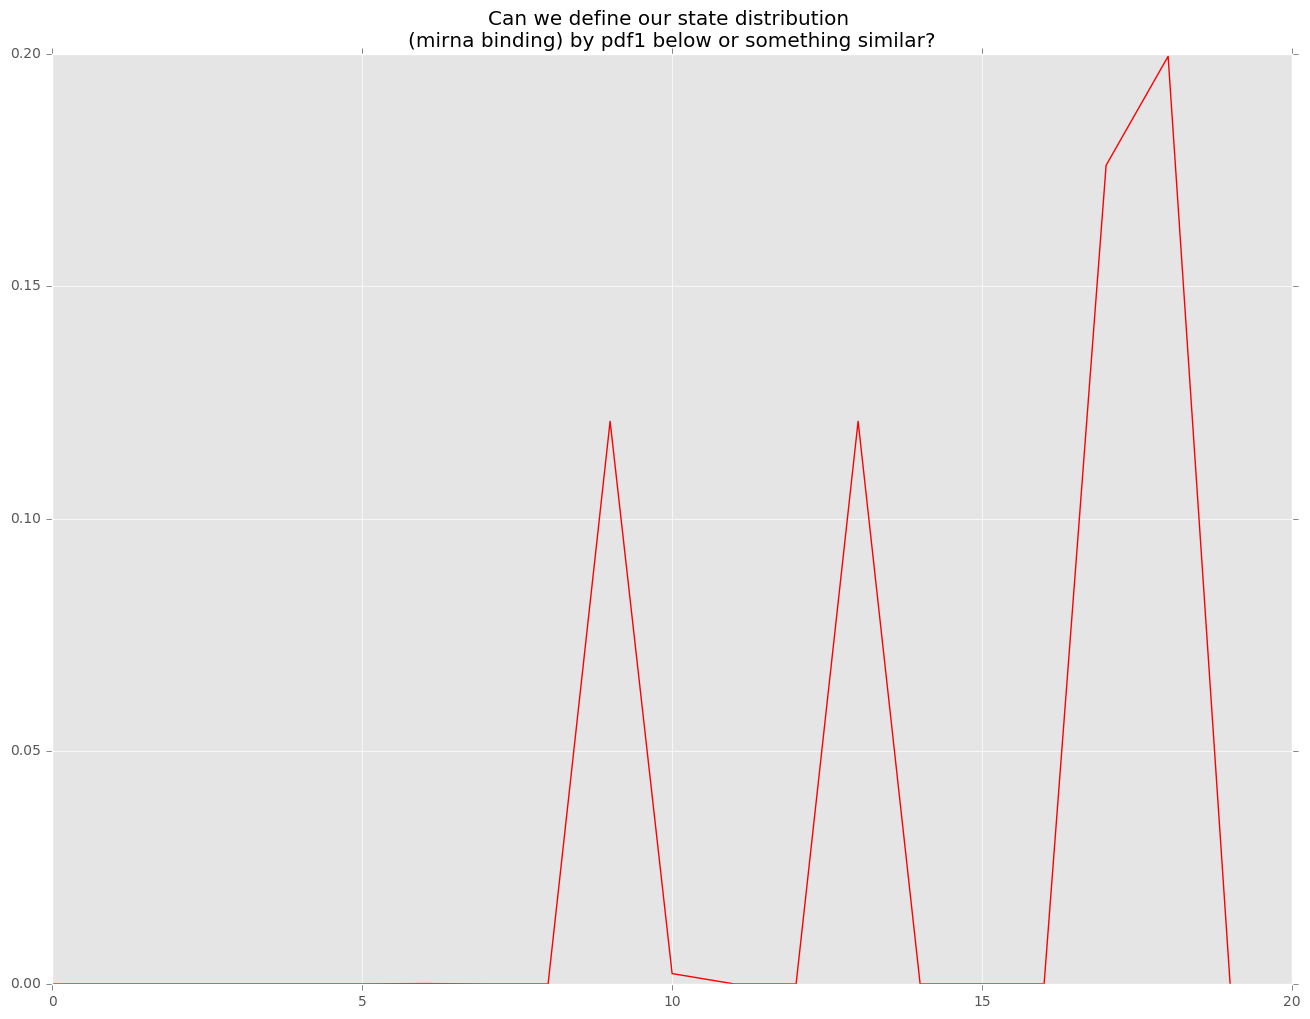

In [24]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html
pdf1 = norm.pdf(pcounts,loc=pcounts[9]-2,scale=2)
plt.plot(pdf1,'r')
plt.title("Can we define our state distribution \n(mirna binding) by pdf1 below or something similar?")
plt.show()
#this approach is too "manually determined" and couldn't be used within the
#pomegranate framework

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


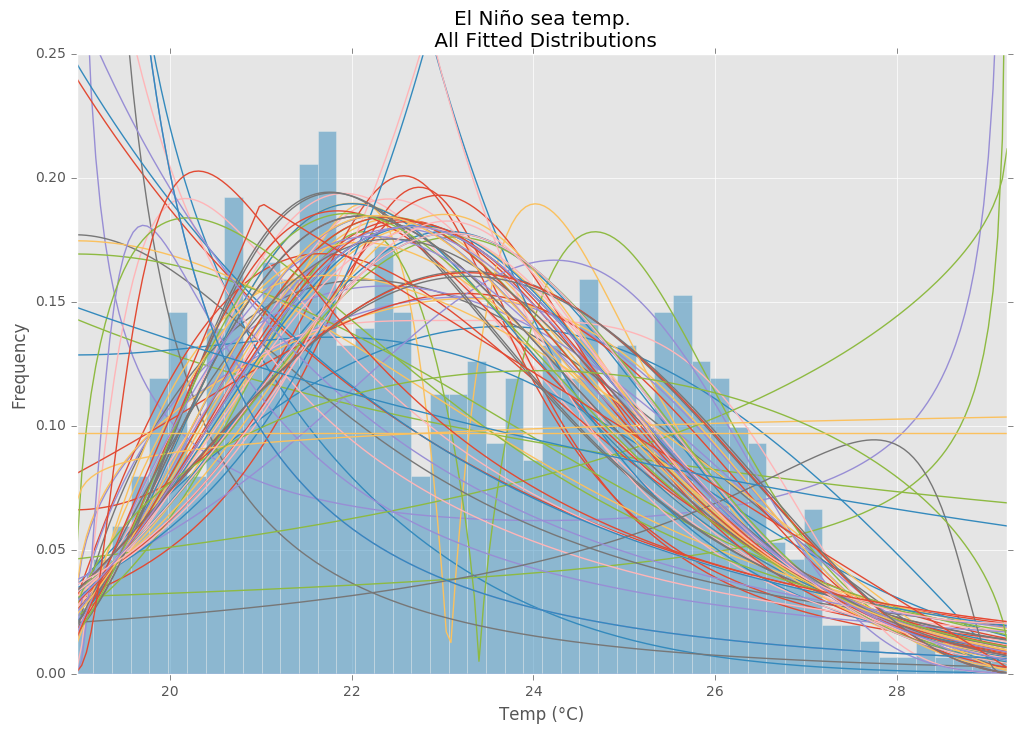

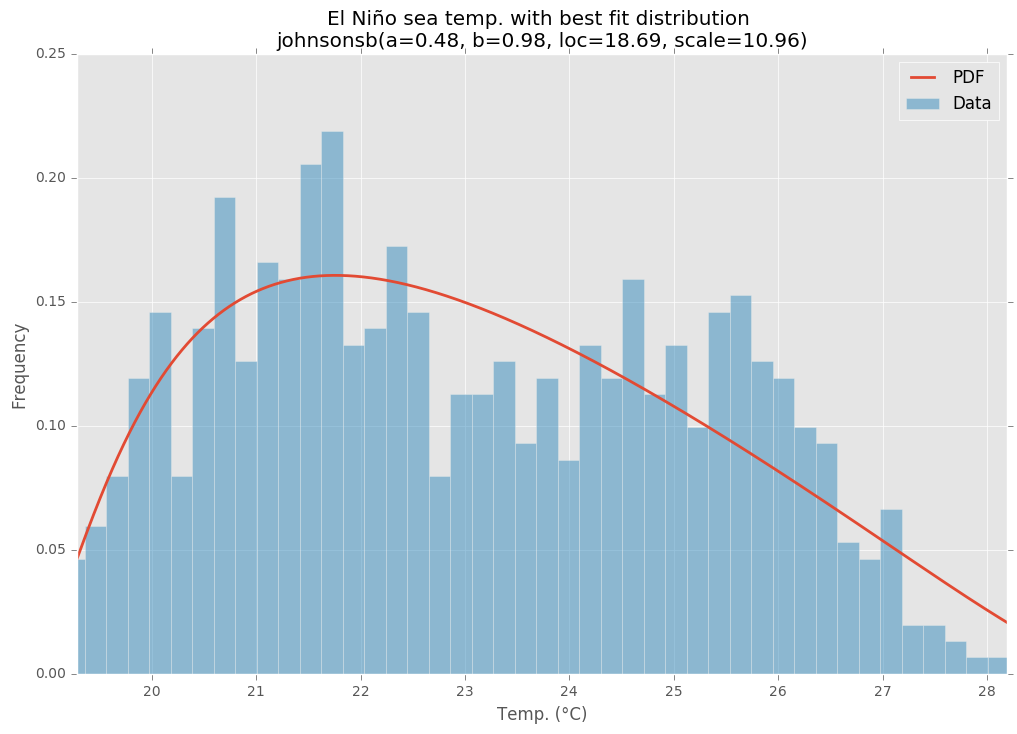

In [5]:
#We need to find a theoretical distribution to fit our data. 
#In pomegranate, we will eventually have to convert
#the distribution into json format to define our state distributions. 
#I found a stackoverflow thread http://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
#that has code for finding the best distribution fit from all scipy distributions
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, normed=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Propbability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(sm.datasets.elnino.load_pandas().data.set_index('YEAR').values.ravel())

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_fit_name, best_fir_paramms = best_fit_distribution(data, 200, ax)
best_dist = getattr(st, best_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'El Niño sea temp.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

# Make PDF
pdf = make_pdf(best_dist, best_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fir_paramms)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u'El Niño sea temp. with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Temp. (°C)')
ax.set_ylabel('Frequency')

//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


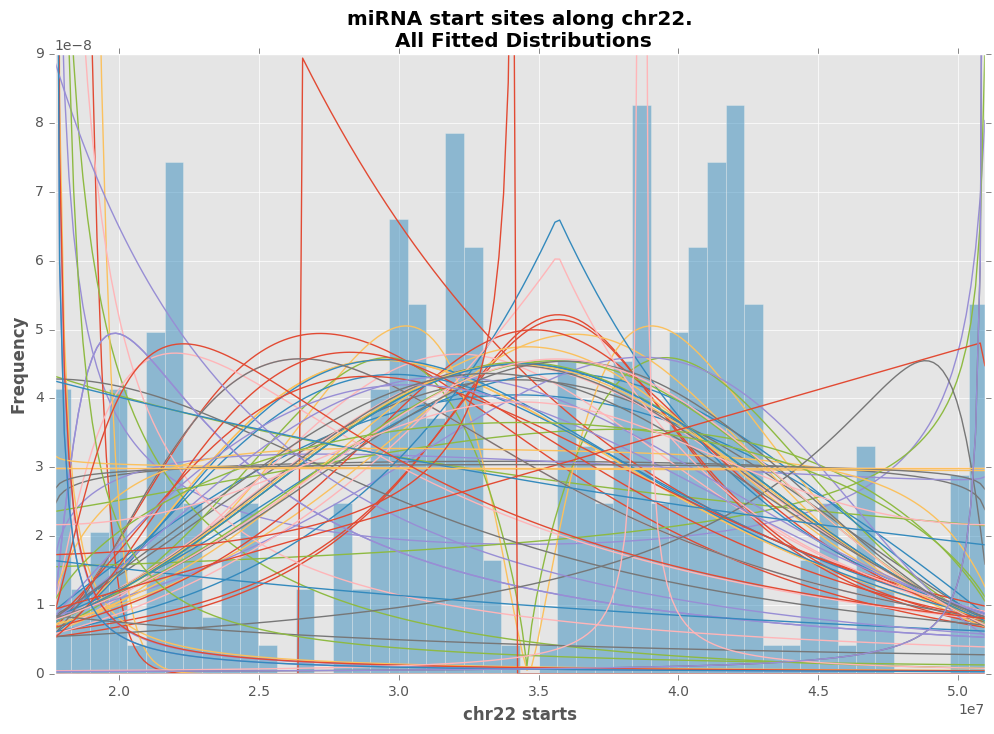

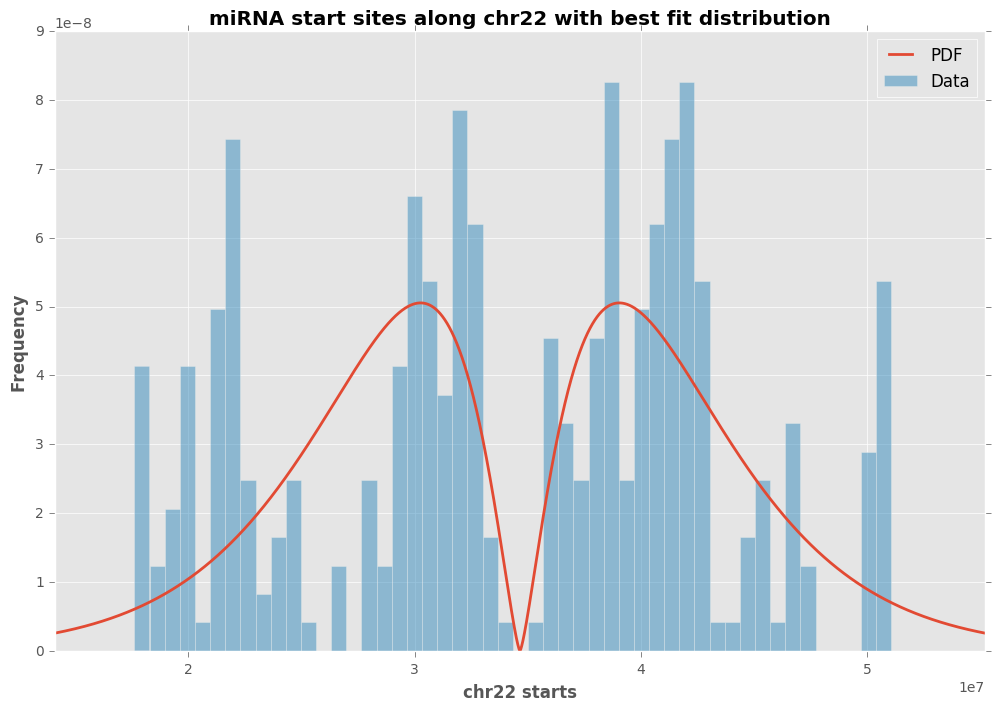

In [7]:
#Using our positive set data

# Load start sites of miRNAs along chr22
data = pd.Series(pmatrix_full.s)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
pbest_fit_name, pbest_fir_paramms = best_fit_distribution(data, 200, ax)
pbest_dist = getattr(st, pbest_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'miRNA start sites along chr22.\n All Fitted Distributions',fontweight='bold')
ax.set_xlabel(u'chr22 starts',fontweight='bold')
ax.set_ylabel('Frequency',fontweight='bold')

#
plt.savefig('/Users/nickgiangreco/GitHub/HMMicro/data/mirna_sites_all_fitted_distributions.png')

# Make PDF
pdf = make_pdf(pbest_dist, pbest_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (pbest_dist.shapes + ', loc, scale').split(', ') if pbest_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, pbest_fir_paramms)])
dist_str = '{}({})'.format(pbest_fit_name, param_str)

ax.set_title(u'miRNA start sites along chr22 with best fit distribution',fontweight='bold')
ax.set_xlabel(u'chr22 starts',fontweight='bold')
ax.set_ylabel('Frequency',fontweight='bold')

plt.savefig('/Users/nickgiangreco/GitHub/HMMicro/data/mirna_sites_best_fitted_distribution.png')



//anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:898: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


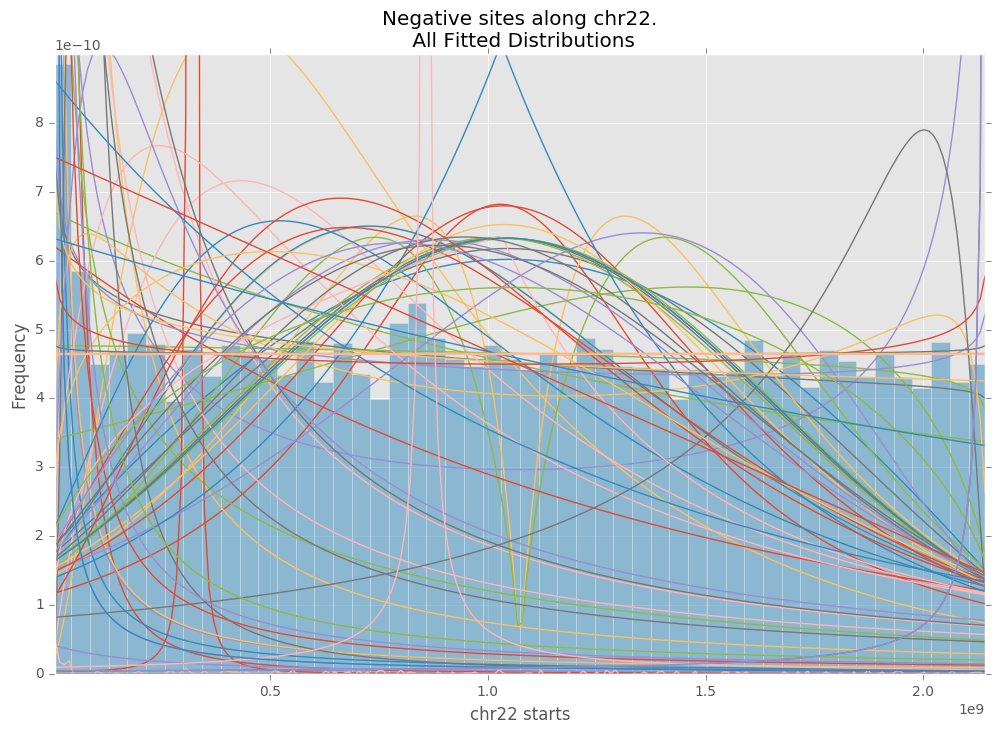

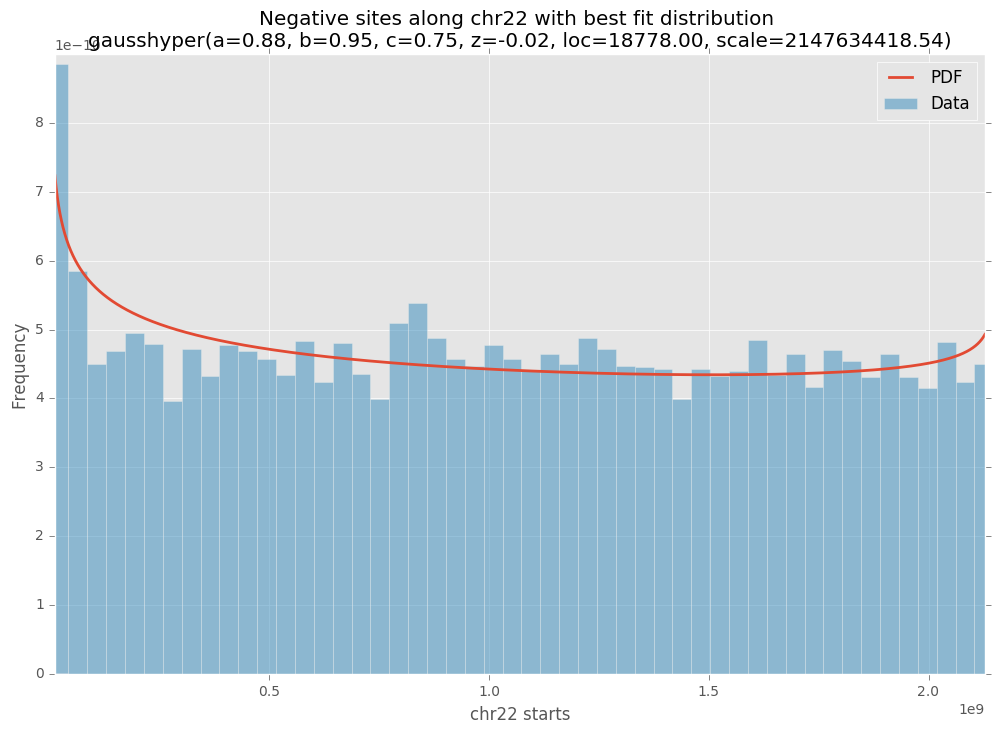

In [25]:
#Using our negative set data

# Load start sites of miRNAs along chr22
data = pd.Series(nmatrix_full.s)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, normed=True, alpha=0.5, color=plt.rcParams['axes.color_cycle'][1])
# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
nbest_fit_name, nbest_fir_paramms = best_fit_distribution(data, 200, ax)
nbest_dist = getattr(st, nbest_fit_name)

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Negative sites along chr22.\n All Fitted Distributions')
ax.set_xlabel(u'chr22 starts')
ax.set_ylabel('Frequency')

plt.savefig('/Users/nickgiangreco/GitHub/HMMicro/data/negative_sites_all_fitted_distributions.png')


# Make PDF
pdf = make_pdf(nbest_dist, nbest_fir_paramms)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (nbest_dist.shapes + ', loc, scale').split(', ') if nbest_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, nbest_fir_paramms)])
dist_str = '{}({})'.format(nbest_fit_name, param_str)

ax.set_title(u'Negative sites along chr22 with best fit distribution \n' + dist_str)
ax.set_xlabel(u'chr22 starts')
ax.set_ylabel('Frequency')

plt.savefig('/Users/nickgiangreco/GitHub/HMMicro/data/negative_sites_best_fitted_distribution.png')



In [26]:
#for positive set
#Translating to what pomegranate can use
#https://media.readthedocs.org/pdf/pomegranate/latest/pomegranate.pdf
#Can we do a mixture instead or something?
from pomegranate import *
g = GammaDistribution(pbest_fir_paramms[0],pbest_fir_paramms[1],pbest_fir_paramms[2])
g

{
    "frozen" :true,
    "name" :"GammaDistribution",
    "parameters" :[
        2.3908060000735496,
        34648812.405860215
    ],
    "class" :"Distribution"
}